In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime
from unidecode import unidecode
import re
import copy
import pickle
from scipy.stats import chi2, weibull_min
import lifelines


We first download the necessary data from previous notebooks. Namely the expected goals model and the associated parameters. 

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
# Load game events
with open('data/game_events.pkl', 'rb') as f:
    game_events = pickle.load(f)


# Get xg model parameters 
with open('data/xg_rate_parameters.pkl', 'rb') as f:
    xg_rate_parameters = pickle.load(f)



# Get xg model matrix 
with open('data/xg_data_matrix.pkl', 'rb') as f:
    data_with_dummies = pickle.load(f)

# Get general data matrix
with open('data/general_data_matrix.pkl', 'rb') as f:
    data = pickle.load(f)



# Get xg model 
with open('data/xg_model.pkl', 'rb') as f:
    xg_model = pickle.load(f)





# Hazard Function Fitting
We will model goal scoring timings as time to event data with right censoring. Motivated by previous work, we model the time between goals using a weibull distribution. Given that we know that the number of goals in a time period of length $t$ will have a distribution with mean $rt$ where $r$ is the goal scoring rate, we use the expected goals model fit for a game state as our baseline. Call this value $r(G)$. We believe that the time to goal should be weibull distributed with mean $1/r(G)$. Our goal is to find the shape parameter $k$.  

In [39]:
#initialize hazard data 
hazard_data = data.copy()
#add expected goal data 
hazard_data['predicted_xg'] = data_with_dummies['predicted_xg']
hazard_data['predicted_xg_rate'] = data_with_dummies['predicted_xg']/data_with_dummies['period_length']
hazard_data['xg'] = hazard_data['xg_rate']*hazard_data['period_length']

## First Goal Timings and Rates
To fit our model,we choose to only look at the timing of the first goal scored for each team in the first half of each game. The reason is that this data is the most ubiquitous and that most substitutions occur in the second half. Therefore, the periods with the longest constant game state are in the first half. 

In [40]:
#get length of game events 
n = len(game_events)
#save first goal for each team for each game 
first_goal = {}
#iterate over games 
for key in game_events:
    game = game_events[key]
    #get team names 
    home_team_name = game['home_team_name']
    away_team_name = game['away_team_name']
    #get game data 
    data = game['data']
    #intialize goal scoring times 
    first_goal[key] = {home_team_name:None, away_team_name: None}
    #over each event, look for goal sin teh first half before extra time 
    for j in range(len(data)):
        event = data[j]
        if event['half'] == 1 and event['extra_time'] == 0:
            change = event['change_type']
            if (change == tuple(("Goal",home_team_name)) or change == tuple(("Own Goal",away_team_name))) and (first_goal[key][home_team_name] is None):
                first_goal[key][home_team_name]= event['time_end'] 
            elif (change == tuple(("Goal",away_team_name)) or change == tuple(("Own Goal",home_team_name))) and (first_goal[key][away_team_name] is None):
                first_goal[key][away_team_name] = event['time_end']


In [41]:
n = hazard_data.shape[0]
#get scoring rates for each team at beginning of each game 
first_goal_rate = {}
#iterate over hazard data
for j in range(n):
    game = hazard_data.iloc[j]
    #get game id 
    id = game['id']
    #get home and away teams 
    home_team_name = game_events[id]['home_team_name']
    away_team_name = game_events[id]['away_team_name']
    #match first row
    if id not in first_goal_rate:
        first_goal_rate[id] = {home_team_name:None, away_team_name: None}
    #get team 
    team  = game['team']
    #add team rate to fist_goal
    if first_goal_rate[id][team] is None:
        first_goal_rate[id][team] = game['predicted_xg_rate']
    

    

In [42]:
#list of first goal timings 
first_goal_timing = []
#list of associated goal scoring rates 
team_scoring_rates = []
for key in first_goal:
    A = first_goal[key]
    for key2 in A:
        first_goal_timing.append(A[key2])
        team_scoring_rates.append(first_goal_rate[key][key2])
        

## Plotting Goals/90 
We see that most teams first half goal scoring rate is between 0.9 and 1.35 goals/90. As such, we filter the data to only include these teams. This is becasue we want the rates to be as close to uniform as we can without wasting too much data.

Text(0.5, 1.0, 'Histogram of Team Season Scoring Rates (xg/90)')

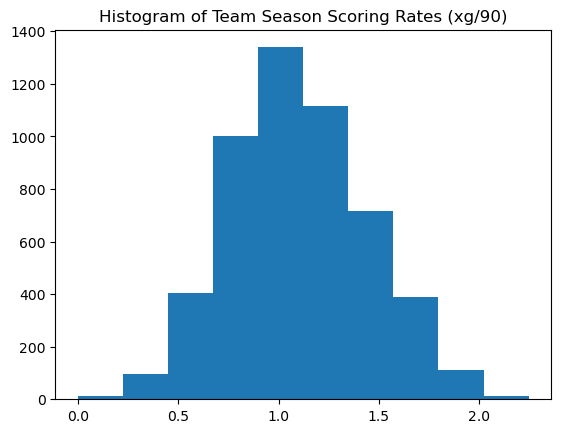

In [43]:
plt.hist(np.array(team_scoring_rates)*90)
plt.title("Histogram of Team Season Scoring Rates (xg/90)")

We see that a weibull with shape parameter 1.1 looks like a decent fit for the observed data. The MLE estimate is found to be 1.1162 as seen below. 

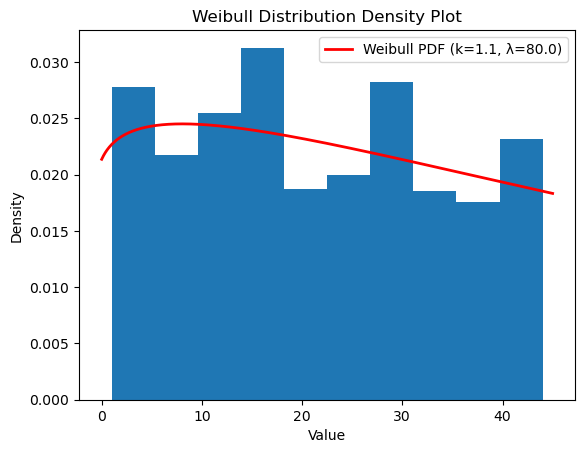

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import weibull_min

plt.hist([first_goal_timing[j] for j in range(len(first_goal_timing)) if team_scoring_rates[j] > 0.010 and team_scoring_rates[j] < 0.015 and first_goal_timing[j] is not None and first_goal_timing[j] < 45],density = True,bins = 10)
# Define the shape and scale parameters for the Weibull distribution
shape = 1.1  # Example shape parameter (k)
scale = 1/0.01250  # Example scale parameter (λ)

# Generate x values over a range where you want to plot the Weibull distribution
x = np.linspace(0, 45, 1000)

# Calculate the Weibull PDF
weibull_pdf = weibull_min.pdf(x+1, shape, scale=scale)/(weibull_min.cdf(45, shape, scale=scale))

# Plot the Weibull PDF
plt.plot(x, weibull_pdf, 'r-', linewidth=2, label=f'Weibull PDF (k={shape}, λ={scale})')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Weibull Distribution Density Plot')
plt.legend()

# Show the plot
plt.show()


The MLE for k is approximately 1.1162


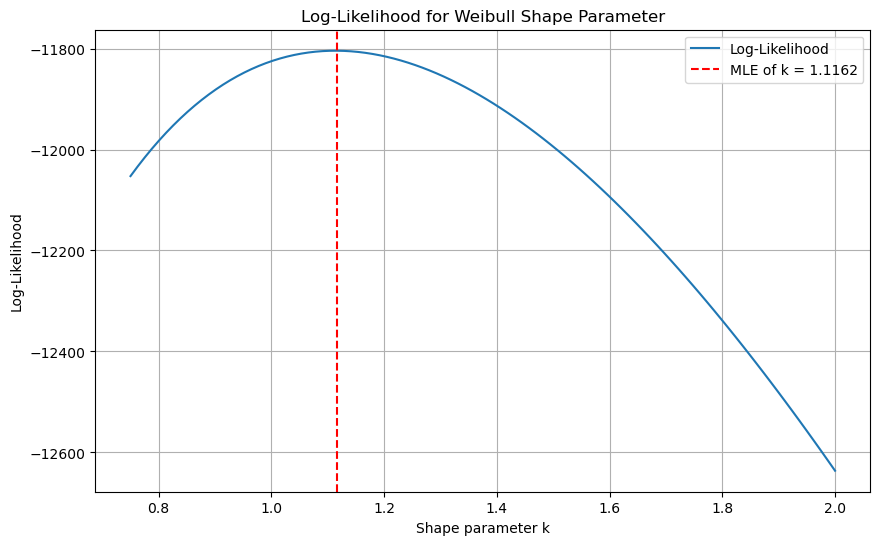

In [45]:
# Define the range of k values to search
k_range = np.linspace(0.75, 2, 100)

# Initialize a list to store likelihood values
liks = []

# Define the scale parameter (assuming a known rate, e.g., 0.0125)
scale = 1 / 0.01250

# Loop over the range of k values
for k in k_range:
    lik = 0
    for val in first_goal_timing:
        if val is None or val > 45:
            # Handle censored data (where the event didn't happen within 45 minutes)
            lik += np.log(1 - weibull_min.cdf(45, k, scale=scale))
        else:
            # Handle observed data (where the event happened within the observed time)
            lik += np.log(weibull_min.pdf(val, k, scale=scale))
    liks.append(lik)

# Convert the list of likelihoods to a numpy array
liks = np.array(liks)

# Find the k value that maximizes the likelihood
best_k = k_range[np.argmax(liks)]

print(f"The MLE for k is approximately {best_k:.4f}")

# Plot the likelihood function over the range of k values
plt.figure(figsize=(10, 6))
plt.plot(k_range, liks, label='Log-Likelihood')
plt.axvline(best_k, color='r', linestyle='--', label=f'MLE of k = {best_k:.4f}')
plt.xlabel('Shape parameter k')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood for Weibull Shape Parameter')
plt.legend()
plt.grid(True)
plt.show()


### Hazard function of data vs exponential fit 
We see that if we fit our data using an exponential distribution, we are much too aggressive as the observed data stochastically dominates our proposed distribution. 

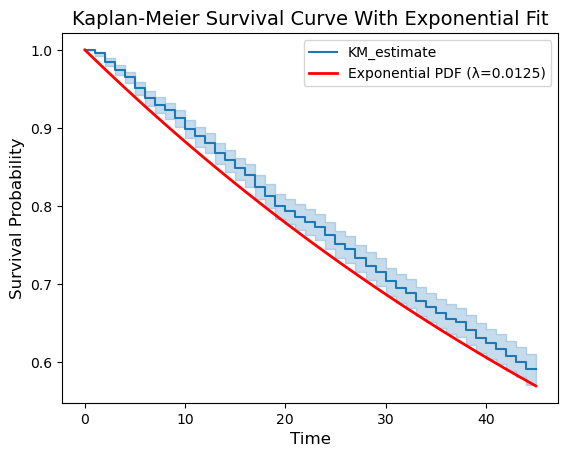

In [54]:
# Assuming you have your termination times and event observed in lists
termination_times = []
event_observed = []
n = len(first_goal_timing)
for j in range(n):
    if (team_scoring_rates[j] > 0.010 and team_scoring_rates[j] < 0.015) == False:
        continue
    elif first_goal_timing[j] is None or first_goal_timing[j] > 45:
        termination_times.append(45)
        event_observed.append(0)
    else:
        termination_times.append(first_goal_timing[j])
        event_observed.append(1)


# Create a Kaplan-Meier Fitter instance
kmf = lifelines.KaplanMeierFitter()

# Fit the data
kmf.fit(termination_times, event_observed=event_observed)

# Plot the Kaplan-Meier estimate
kmf.plot_survival_function()
# Generate x values for the exponential density plot
x = np.linspace(0, 45, 100)

# Calculate the exponential density function
rate = 0.0125
exp_density =  np.exp(-rate * x)

# Overlay the exponential density plot
plt.plot(x, exp_density, 'r-', linewidth=2, label=f'Exponential PDF (λ={rate})')

# Customize your plot
plt.title('Kaplan-Meier Survival Curve With Exponential Fit',fontsize = 14)
plt.xlabel('Time',fontsize = 12)
plt.ylabel('Survival Probability',fontsize = 12)
plt.legend()

#save plot
plt.savefig("figures/kapaln_meier_exponential.pdf")
# Show the plot
plt.show()


### Hazard function of data vs weibull fit
Meanwhile we see that a weibull fit using our MLE estimate for the shape parameter is a near perfect fit. This suggests that using a weibull distribution is appropriate for our data.

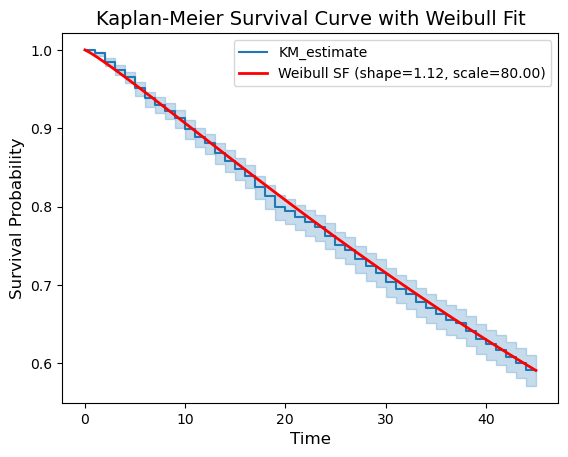

In [53]:
# Assuming you have your termination times and event observed in lists
termination_times = []
event_observed = []
n = len(first_goal_timing)
for j in range(n):
    if not (0.010 < team_scoring_rates[j] < 0.015):
        continue
    elif first_goal_timing[j] is None or first_goal_timing[j] > 45:
        termination_times.append(45)
        event_observed.append(0)
    else:
        termination_times.append(first_goal_timing[j])
        event_observed.append(1)

# Create a Kaplan-Meier Fitter instance
kmf = lifelines.KaplanMeierFitter()

# Fit the data
kmf.fit(termination_times, event_observed=event_observed)

# Plot the Kaplan-Meier estimate
kmf.plot_survival_function()

# Fit a Weibull distribution to the data
#shape, loc, scale = weibull_min.fit(termination_times, floc=0)  # fixing location to 0

# Generate x values for the Weibull density plot
x = np.linspace(0, 45, 100)

shape = best_k
scale = 1/0.0125
# Calculate the Weibull survival function
weibull_sf = weibull_min.sf(x, shape, loc=0, scale=scale)

# Overlay the Weibull survival function plot
plt.plot(x, weibull_sf, 'r-', linewidth=2, label=f'Weibull SF (shape={shape:.2f}, scale={scale:.2f})')

# Customize your plot
plt.title('Kaplan-Meier Survival Curve with Weibull Fit',fontsize = 14)
plt.xlabel('Time',fontsize = 12)
plt.ylabel('Survival Probability',fontsize = 12)
plt.legend()


#save plot
plt.savefig("figures/kapaln_meier_weibull.pdf")
# Show the plot
plt.show()
